In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

from langdetect import detect
import re

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [3]:
GOOD_REVIEW_THRESHOLD = 7

In [4]:
VAL_FRACTION = 0.25

In [217]:
MIN_COMMENT_LEN = 25

In [65]:
TOP_N = 5

## GET DATA

In [6]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [7]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [8]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '316624',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/eUiju5SqZbkNt8gnEofrTw__thumb/img/zNkmLNyeXJGOY24FeAAf4U67ejU=/fit-in/200x150/filters:strip_icc()/pic6035127.png',
  'name': 'Stationfall',
  'yearpublished': '2021'},
 {'id': '328866',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/N0hCcxXw8d7vUjKfsYO6vg__thumb/img/K4DDlRzl6qlQf9L_oMLb7g9WUYo=/fit-in/200x150/filters:strip_icc()/pic6121929.png',
  'name': "My Father's Work",
  'yearpublished': '2021'}]

In [218]:
try:
    comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,316624,abubrooklyn,10,Do yourself a favor and play this game.
1,316624,ajewo,N/A,Stationsfall seems to be similar to Nemesis. ...
2,316624,Andy Mesa,10,This game tells the best stories of any game I...
3,316624,bradray,N/A,21/12 - Soloable
4,316624,brewsaki,9,"The party game for heavy gamers. Okay, probabl..."
...,...,...,...,...
104238,68448,_Dani_,N/A,My #1 on DSP 2011.
104239,68448,_mun_,9,A játékosok minden körben egyszerre cselekszen...
104240,68448,_teece_,7,Really enjoyable game and amazing that it stre...
104241,68448,_The_Inquiry_,6,Prior to 2020: 10 plays (est) 7 Wonders is ev...


## DATA CLEANING

In [219]:
comments_df["value"] = comments_df["value"].astype(str)

In [220]:
# REMOVE URLs FROM COMMENTS

In [221]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [222]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25):
    df_local = df.copy()
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len}")
    return df_local.reset_index(drop=True)

In [223]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 34056 for 'remove_short_comments' - min len: 25


In [224]:
# REMOVE NON ENGLISH COMMENTS

In [225]:
# !conda install -c conda-forge langdetect

In [226]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [227]:
# comments_df = add_comments_lang(comments_df)

In [228]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [229]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9.0        12343
10.0       11616
8.0        11528
7.0         6984
N/A         6764
           ...  
6.08667        1
8.765          1
9.72           1
6.011          1
7.21           1
Name: rating, Length: 453, dtype: int64

In [230]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(63423, 5)

In [231]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6764, 5)

## CREATE TRAINING AND VALIDATION DATA

In [232]:
# use rated comments (reviews) to train the model

In [233]:
rated_comments = rated_comments.sample(frac=1)

In [234]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [235]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Nice game with friendly playing time and easy to learn rules.'

In [236]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Much better game than the "big" Arkham Horror.'

In [237]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [238]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.30904898,  0.0426244 ,  0.06704538,  0.25996467, -0.2619953 ,
         0.12377638, -0.19020638, -0.1222228 , -0.45204136,  0.07384369,
         0.0467963 ,  0.22508994,  0.0393021 ,  0.1538818 ,  0.10912731,
        -0.16862948, -0.04795834, -0.03477287,  0.3615784 , -0.35838416,
         0.07312745, -0.14819604, -0.1870862 ,  0.12187824, -0.02361472,
        -0.16282529, -0.19692731, -0.09176803,  0.0179088 , -0.17505665,
         0.07786035, -0.10585915,  0.28630716, -0.07353078, -0.11471184,
         0.03857967,  0.13187747,  0.10094928,  0.05142411, -0.48443797,
         0.05814169,  0.01173291,  0.14104818, -0.07508863,  0.00894789,
         0.12822057, -0.06567207, -0.00755305,  0.09800053,  0.26888004],
       [ 0.09385131,  0.08025346,  0.02402568,  0.1437748 , -0.09771669,
        -0.05520868,  0.19667737,  0.14844164, -0.34029925,  0.17662294,
         0.0732965 ,  0.21998864,  0.14916152,  0.23142776, -0.02090847,
 

In [239]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_4 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [240]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [241]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Train on 47568 samples, validate on 15855 samples
Epoch 1/40
47568/47568 - 29s - loss: 0.4974 - accuracy: 0.8174 - val_loss: 0.4070 - val_accuracy: 0.8302
Epoch 2/40
47568/47568 - 29s - loss: 0.3456 - accuracy: 0.8534 - val_loss: 0.3376 - val_accuracy: 0.8585
Epoch 3/40
47568/47568 - 29s - loss: 0.2833 - accuracy: 0.8838 - val_loss: 0.3227 - val_accuracy: 0.8651
Epoch 4/40
47568/47568 - 29s - loss: 0.2445 - accuracy: 0.9014 - val_loss: 0.3339 - val_accuracy: 0.8643
Epoch 5/40
47568/47568 - 29s - loss: 0.2150 - accuracy: 0.9158 - val_loss: 0.3428 - val_accuracy: 0.8597
Epoch 6/40
47568/47568 - 29s - loss: 0.1922 - accuracy: 0.9265 - val_loss: 0.3610 - val_accuracy: 0.8539
Epoch 7/40
47568/47568 - 29s - loss: 0.1737 - accuracy: 0.9359 - val_loss: 0.3861 - val_accuracy: 0.8501
Epoch 8/40
47568/47568 - 29s - loss: 0.1583 - accuracy: 0.9423 - val_loss: 0.4118 - val_accuracy: 0.8477


In [242]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [243]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [244]:
epochs = range(1, len(acc) + 1) 

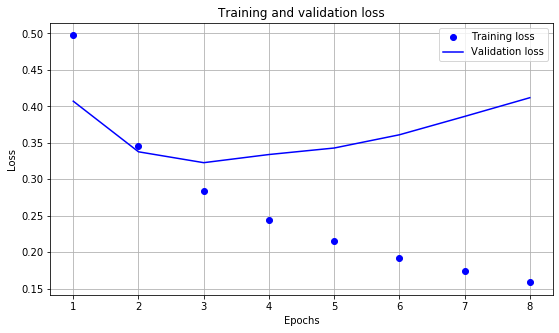

In [245]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

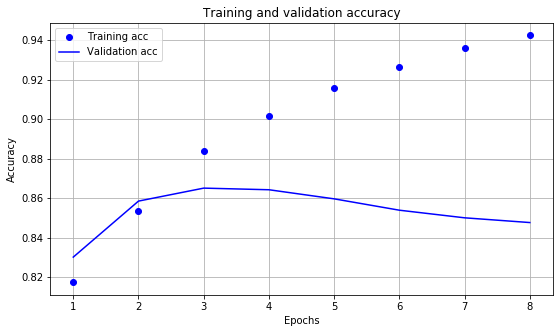

In [246]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [247]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [248]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"Designer: Vital Lacerda Playing time: 90-150 Min Weight: 4.63 / 5 Publisher: Eagle-Gryphon Games  [b]COMPLEXITY: High COMPONENTS: High DOWNTIME: Medium FUN: Medium INTERACTION: Medium PLAYING TIME: High LUCK: Low REPLAY VALUE: High SOLITAIRE: Medium THEMATIC: Medium[/b]  [b]Comments:[/b] [thing=184267][/thing] is a heavy strategy game in which players are trying to make the most advanced colony on Mars. Players have a plethora of possible actions, and icons enough to bring down a space station. Nothing less than what is expected in a Vital Lacerda game.  During play you will make buildings (mines, power generators, water extractors, greenhouses, oxygen factories, and shelters), hire scientists, get blueprints, develop technologies, gather resources, build space ships, get more workers, move around your rover and bots, take end game goals, and so on. The most unique part of the whole game is that the actions are divided in two sections: Mars and the space station. You can only d

In [195]:
## APPLY MODEL ON NON-RATED COMMENTS

In [196]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Spiel.digital20"
score: 0.450875

input:
"Deutsche Retail Edition (2020)"
score: 0.955479

input:
"Added Herb Witches expansion."
score: 0.999009

input:
"Estimated, April 2021"
score: 0.997801

input:
"Mike #19 solo game"
score: 0.990897

input:
"Daniel's.  Sleeved w/ errata pack.  Includes playtest materials for Jagged Earth."
score: 0.999705

input:
"X-Upgrade Pack (KS)"
score: 0.618693

input:
"x Herb Witches"
score: 0.999008

input:
"Economic Games"
score: 0.852940

input:
"strategy economic card management space: mars "
score: 0.817045

input:
"PAX UNPLUGGED 2018"
score: 0.997518

input:
"Bought it today as a Champion"
score: 0.991805

input:
" Inkl. Feldherr Inlay"
score: 0.986108

input:
"Print and Play, created"
score: 0.975314

input:
"- Inventar vollständig: 18.03.2020"
score: 0.546113

input:
"Secret Santa 2020 - can't wait to play!  Thanks, Santa!"
score: 0.997987

input:
"Kickstarter deluxe, all stretch goals limited ed: 15358 / 20000 includes clay chips"
score: 0

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [197]:
rated_comments.head()

,id,username,rating,value,comment_len
57779,162886,sid_staddon,8.8,"One solo play in - it is very, very good",29
7505,298047,kingsburglar,8.5,Kickstarter,11
82650,68448,roderic,7,"Surprising depth or such a snappy little game,...",172
52354,199792,toblerdrone,5.5,"Derivative worker placement, tableau building ...",590
33559,167791,chiefarmorer,10,Really nice theme and game play. Works best i...,73


In [198]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
rated_comments_grouped.head()

,id,rating_mean,rating_count
0,68448,7.666599,10650
1,124361,8.163068,3366
2,162886,8.338957,3127
3,167355,8.372913,1614
4,167791,8.166990,7257


In [199]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [200]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
not_rated_comments_grouped.head()

,id,rating_mean,rating_count
0,68448,8.463096,1111
1,124361,8.735616,438
2,162886,8.654130,569
3,167355,8.665127,433
4,167791,8.767162,874


In [201]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'))
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")

In [202]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url
0,68448,7.666599,10650,8.463096,1111,41,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...,7 Wonders,2010,https://boardgamegeek.com/boardgame/68448
1,124361,8.163068,3366,8.735616,438,44,https://cf.geekdo-images.com/CzwSm8i7tkLz6cBnr...,Concordia,2013,https://boardgamegeek.com/boardgame/124361
2,162886,8.338957,3127,8.654130,569,17,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017,https://boardgamegeek.com/boardgame/162886
3,167355,8.372913,1614,8.665127,433,36,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...,Nemesis,2018,https://boardgamegeek.com/boardgame/167355
4,167791,8.166990,7257,8.767162,874,22,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...,Terraforming Mars,2016,https://boardgamegeek.com/boardgame/167791


In [203]:
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) / (grouped['rating_count_review']+grouped['rating_count_comments'])

In [204]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url,fixed_rating
0,68448,7.666599,10650,8.463096,1111,41,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...,7 Wonders,2010,https://boardgamegeek.com/boardgame/68448,7.741840
1,124361,8.163068,3366,8.735616,438,44,https://cf.geekdo-images.com/CzwSm8i7tkLz6cBnr...,Concordia,2013,https://boardgamegeek.com/boardgame/124361,8.228992
2,162886,8.338957,3127,8.654130,569,17,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017,https://boardgamegeek.com/boardgame/162886,8.387478
3,167355,8.372913,1614,8.665127,433,36,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...,Nemesis,2018,https://boardgamegeek.com/boardgame/167355,8.434725
4,167791,8.166990,7257,8.767162,874,22,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...,Terraforming Mars,2016,https://boardgamegeek.com/boardgame/167791,8.231503


In [205]:
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')

In [206]:
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

In [207]:
grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [208]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [209]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Stationfall,9.500000,8.366667,8.963158,1,2021
2,,My Father's Work,6.125000,9.140000,8.505263,2,2021
3,,Lost Ruins of Arnak,7.888007,8.456934,8.001959,3,2020
4,,Dune: Imperium,8.119528,8.393798,8.170000,4,2020
5,,Merchants Cove,8.384375,9.128000,8.947727,5,2021


In [210]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Stationfall,9.500000,8.366667,8.963158,1,2021
2,,Eclipse: Second Dawn for the Galaxy,8.771277,8.702069,8.752199,38,2020
3,,Brass: Birmingham,8.661242,8.864625,8.703316,28,2018
4,,Gloomhaven: Jaws of the Lion,8.602615,8.694981,8.620534,16,2020
5,,Kemet: Blood and Sand,8.525000,9.001639,8.934507,40,2021


In [211]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Marvel United: X-Men,8.000000,9.409091,9.347826,25,2022
2,,Stationfall,9.500000,8.366667,8.963158,1,2021
3,,Merchants Cove,8.384375,9.128000,8.947727,5,2021
4,,Kemet: Blood and Sand,8.525000,9.001639,8.934507,40,2021
5,,Eclipse: Second Dawn for the Galaxy,8.771277,8.702069,8.752199,38,2020


In [212]:
# model.save('saved_model\my_model')

In [213]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [214]:
# some examples on "long" comments vs short comments

In [215]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()

In [216]:
# some long comments
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results, limit=25)

input:
"Looks interesting, by the same people as Vast: the Crystal Caverns. I own that game but have not yet played it. Need to get it to the table and then look forward at this and see what I think."
score: 0.905942

input:
"Great drafting game.  this title makes it to the table more often than most.  Our sweet spot is 3 players."
score: 0.999403

input:
"LD. Beautiful design and components. Mechanics are well balanced and play smoothly. Theme feels completely pasted on, game is actually pretty abstract like Terra Mystica. Collector's edition has much better bits. Played digital edition, it is as abstract as chess. Not my cup of tea. +/-"
score: 0.095900

input:
"+ Forgotten Circles + Solo quests  + Removable sticker set + Forgotten Circles removable sticker set  + Folded Space organizer"
score: 1.000000

input:
":star:[b][size=16][COLOR=#FFFFFF][BGCOLOR=#800080]Preorder Collector's Edition March 2021[/BGCOLOR][/COLOR][/size][/b]  [b][size=10][BGCOLOR=#D68910]Need 123 7 wonders Sleeve